![alt](https://research.utm.my/wp-content/uploads/sites/26/2022/06/logo-300x122.png)
# Center for Artificial Intelligence and Robotics
#### Universiti Teknologi Malaysia


### Detection Inference - FasterRCNN

*Author: Dr. Ibrahim, Azzam, Thaqif & Syahmi*

**FasterRCNN for object detection.**

_ | _

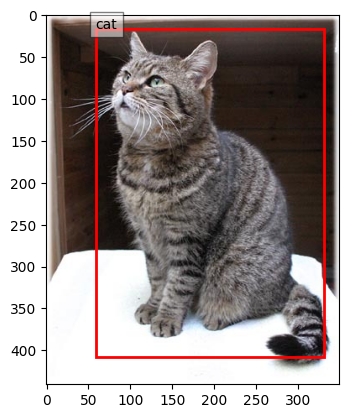

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests

# URL to the COCO class names
url = 'https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt'

# Download the class names
response = requests.get(url)
coco_classes = ['background'] + response.text.strip().split('\n')

# Load the Faster R-CNN model pre-trained on COCO dataset
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Load an image
image_path = 'test_images/cat.jpg'
image = Image.open(image_path).convert('RGB')
# Preprocess the image
transform = transforms.Compose([
    transforms.ToTensor(),
])
input_tensor = transform(image).unsqueeze(0)

# Perform object detection
with torch.no_grad():
    predictions = model(input_tensor)

# Process the predictions
pred_boxes = predictions[0]['boxes'].cpu().numpy()
pred_scores = predictions[0]['scores'].cpu().numpy()
pred_labels = predictions[0]['labels'].cpu().numpy()

# Set a confidence threshold
confidence_threshold = 0.5
filtered_boxes = pred_boxes[pred_scores >= confidence_threshold]
filtered_labels = pred_labels[pred_scores >= confidence_threshold]

# Map the labels to class names
pred_class_names = [coco_classes[label] for label in filtered_labels]

# Visualize the results
fig, ax = plt.subplots(1)
ax.imshow(image)

# Add bounding boxes to the image
for box, label in zip(filtered_boxes, pred_class_names):
    x1, y1, x2, y2 = box
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(x1, y1, f'{label}', bbox=dict(facecolor='white', alpha=0.5))

plt.show()

# Fish Detection with Faster R-CNN

This section demonstrates how to load a custom-trained Faster R-CNN model using a ResNet-50 backbone on a Jetson device and use it for object detection. The example provided focuses on detecting objects in a fish dataset.

## Sections

1. Prerequisites
2. Import Necessary Libraries
3. Set Up the Dataset
4. Load the Trained Model
5. Prediction Function
6. Visualize Prediction
7. Example Usage
8. Conclusion


In [10]:
import os
import torch
import torchvision
from torchvision import models
from pycocotools.coco import COCO

# Define the dataset path and classes
dataset_path = '___'

# Load classes from the dataset annotations
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
classes = [i[1]['name'] for i in categories.items()]
num_classes = len(classes)

# Function to load the trained model
def load_trained_model(model_path, num_classes):
    # Initialize the model with the same architecture
    model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=False)
    
    # Replace the head with the appropriate number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    
    # Load the trained weights
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

# Example usage
model_path = '___'  # Replace with your model's file path
trained_model = load_trained_model(model_path, num_classes)

# Function to perform inference
def predict(image, model, device):
    model.to(device)
    image = [image.to(device)]
    model.eval()
    with torch.no_grad():
        prediction = model(image)
    return prediction

# Example for visualizing the prediction
def visualize_prediction(image, prediction, threshold=0.8):
    from torchvision.utils import draw_bounding_boxes
    import matplotlib.pyplot as plt

    boxes = prediction[0]['boxes']
    scores = prediction[0]['scores']
    labels = prediction[0]['labels']

    # Filter out low score boxes
    keep = scores >= threshold
    boxes = boxes[keep]
    labels = labels[keep]

    # Draw bounding boxes
    drawn_image = draw_bounding_boxes(image.mul(255).byte(), boxes, [classes[i] for i in labels], width=4)

    plt.figure(figsize=(12, 8))
    plt.imshow(drawn_image.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

# Example usage
# Assuming 'image' is a preprocessed tensor and 'device' is 'cpu' or 'cuda'
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# prediction = predict(image, trained_model, device)
# visualize_prediction(image, prediction)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


/usr/local/lib/python3.8/dist-packages/torchvision-0.15.1a0+42759b1-py3.8-linux-aarch64.egg/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100.0%


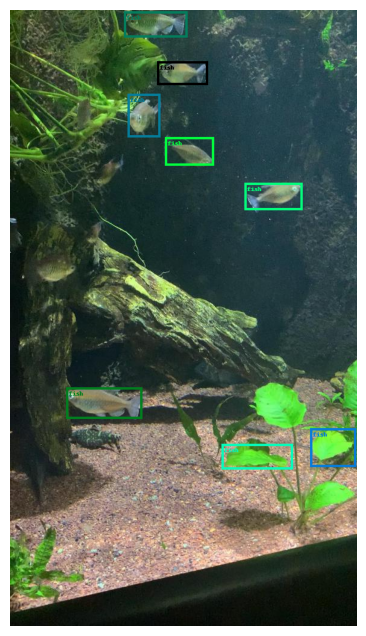

In [11]:
import torch
from torchvision import transforms
from PIL import Image

# Assuming 'device' is 'cpu' or 'cuda'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Replace with your image path
image_path = 'fishdataset/test/IMG_8497_MOV-0_jpg.rf.5c59bd1bf7d8fd7a20999d51a79a12c0.jpg'  # Replace with your image path

# Load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    return transform(image)

# Load and preprocess the image
image = preprocess_image(image_path)

# Perform inference
prediction = predict(image, trained_model, device)

# Visualize the prediction
visualize_prediction(image, prediction)

## Conclusion
This notebook provides a template for loading and using a custom-trained Faster R-CNN model with a ResNet-50 backbone on Jetson devices. You can modify the code to suit your specific use case, such as adjusting the model architecture, dataset, or image preprocessing steps.
